# Train/Valid Press & Report Sampler
Press/report 자료 구조를 자동으로 검사하고, 각 카테고리에서 5개씩 샘플을 미리보기 위한 노트북입니다.

## 1. Configure Environment and Imports
데이터 경로 및 공통 유틸을 한 곳에서 정의해 재사용합니다.

In [1]:
from pathlib import Path
from itertools import product
import json
import random
from typing import Dict, List, Optional

import pandas as pd
from IPython.display import display, Markdown
from PIL import Image
import matplotlib.pyplot as plt

ROOT = Path("data/train_valid").resolve()
SAMPLES_PER_CATEGORY = 5
RNG = random.Random(42)

ROOT

PosixPath('/home/ubuntu/projects/cau/dacon/data/train_valid')

## 2. Inspect Base Dataset Directories
`data/train_valid` 하위의 split(train/valid)을 나열해 press/report 하위 구조를 파악합니다.

In [2]:
collections = sorted([p for p in ROOT.iterdir() if p.is_dir()])
collection_rows = [
    {
        "collection": path.name,
        "contains": sorted(child.name for child in path.iterdir() if child.is_dir()),
        "file_count": sum(1 for child in path.rglob("*") if child.is_file()),
    }
    for path in collections
]
base_overview = pd.DataFrame(collection_rows)
display(base_overview)

collections

,collection,contains,file_count
0,train,"[press_jpg, press_json, report_jpg, report_json]",120980
1,valid,"[press_jpg, press_json, report_jpg, report_json]",21041


[PosixPath('/home/ubuntu/projects/cau/dacon/data/train_valid/train'),
 PosixPath('/home/ubuntu/projects/cau/dacon/data/train_valid/valid')]

## 3. Enumerate Categories per Collection
split 내부의 카테고리 디렉터리를 `(collection, category, modality)` 조합으로 정규화해 파일 개수를 집계합니다.

In [3]:
def split_category_name(name: str) -> Dict[str, str]:
    parts = name.split("_", 1)
    if len(parts) == 2:
        return {"category": parts[0], "modality": parts[1]}
    return {"category": name, "modality": "unknown"}

CATEGORY_RECORDS: List[Dict[str, object]] = []
for collection_path in collections:
    for child in sorted(collection_path.iterdir()):
        if not child.is_dir():
            continue
        parts = split_category_name(child.name)
        file_count = sum(1 for _ in child.iterdir() if _.is_file())
        CATEGORY_RECORDS.append(
            {
                "collection": collection_path.name,
                "category": parts["category"],
                "modality": parts["modality"],
                "path": child,
                "file_count": file_count,
            }
        )

df_categories = (
    pd.DataFrame(CATEGORY_RECORDS)
    .sort_values(["collection", "category", "modality"])
    .reset_index(drop=True)
)
display(df_categories[ ["collection", "category", "modality", "file_count"] ])

len(CATEGORY_RECORDS)

,collection,category,modality,file_count
0,train,press,jpg,14585
1,train,press,json,14585
2,train,report,jpg,45905
3,train,report,json,45905
4,valid,press,jpg,7627
5,valid,press,json,1840
6,valid,report,jpg,5787
7,valid,report,json,5787


8

## 4. Sample Files per Category
카테고리별로 최대 5개 파일을 고정 시드로 무작위 추출하고, 미리보기 텍스트를 생성합니다.

In [4]:
def summarize_file(path: Path) -> str:
    suffix = path.suffix.lower()
    if suffix == ".json":
        try:
            with path.open(encoding="utf-8") as f:
                payload = json.load(f)
        except Exception as exc:
            return f"JSON load failed: {exc}"
        context = (
            payload.get("learning_data_info", {}).get("visual_context")
            or payload.get("raw_data_info", {}).get("doc_name")
            or ""
        )
        context = context.replace("\n", " ").strip()
        snippet = context[:200]
        if len(context) > 200:
            snippet += " ..."
        return snippet
    if suffix in {".jpg", ".jpeg", ".png"}:
        try:
            with Image.open(path) as img:
                return f"Image {img.mode} {img.size[0]}x{img.size[1]}"
        except Exception as exc:
            return f"Image preview failed: {exc}"
    return f"Unsupported file type: {suffix or 'n/a'}"

SAMPLED_CATEGORIES: List[Dict[str, object]] = []
for record in CATEGORY_RECORDS:
    files = [p for p in record["path"].iterdir() if p.is_file()]
    if not files:
        continue
    if len(files) <= SAMPLES_PER_CATEGORY:
        chosen = files
    else:
        chosen = RNG.sample(files, SAMPLES_PER_CATEGORY)
    SAMPLED_CATEGORIES.append({**record, "samples": sorted(chosen)})

len(SAMPLED_CATEGORIES)

8

In [5]:
def guess_json_partner(image_path: Path) -> Optional[Path]:
    json_dir_name = image_path.parent.name.replace("jpg", "json")
    json_dir = image_path.parent.parent / json_dir_name
    if not json_dir.exists():
        return None

    stem = image_path.stem
    candidate_stems = [stem]
    if stem.startswith("MI2"):
        candidate_stems.append("MI3" + stem[3:])
    if stem.startswith("MI1"):
        candidate_stems.append("MI3" + stem[3:])

    for cand in candidate_stems:
        candidate_path = json_dir / f"{cand}.json"
        if candidate_path.exists():
            return candidate_path

    suffix = "_".join(stem.split("_")[-2:])
    matches = sorted(json_dir.glob(f"*{suffix}.json"))
    return matches[0] if matches else None


def extract_image_annotations(image_path: Path) -> List[Dict[str, object]]:
    json_path = guess_json_partner(image_path)
    if not json_path:
        return []
    try:
        with json_path.open(encoding="utf-8") as f:
            payload = json.load(f)
    except Exception as exc:
        return [
            {
                "class_id": "error",
                "class_name": None,
                "bounding_box": None,
                "visual_instruction": "metadata load failed",
                "visual_answer": str(exc),
            }
        ]
    annotations = payload.get("learning_data_info", {}).get("annotation", [])
    enriched = []
    for ann in annotations:
        if "visual_instruction" in ann or "visual_answer" in ann:
            enriched.append(
                {
                    "class_id": ann.get("class_id"),
                    "class_name": ann.get("class_name"),
                    "bounding_box": ann.get("bounding_box"),
                    "visual_instruction": ann.get("visual_instruction"),
                    "visual_answer": ann.get("visual_answer"),
                }
            )
    return enriched


def show_image_with_metadata(image_path: Path, title: str) -> None:
    fig, ax = plt.subplots(figsize=(5, 7))
    with Image.open(image_path) as img:
        ax.imshow(img)
    ax.axis("off")
    ax.set_title(title, fontsize=10)
    plt.tight_layout()
    plt.show()

    annotations = extract_image_annotations(image_path)
    if not annotations:
        display(Markdown("*No annotation metadata found.*"))
        return

    rows = []
    for idx, ann in enumerate(annotations, 1):
        bbox = ann.get("bounding_box")
        if bbox:
            bbox_str = ", ".join(
                f"{float(v):.1f}" if isinstance(v, (float, int)) else str(v) for v in bbox
            )
        else:
            bbox_str = "-"
        rows.append(
            f"**Annotation {idx} (`{ann.get('class_id')}`)**  "
            f"\n- bbox: {bbox_str}  "
            f"\n- prompt: {ann.get('visual_instruction') or '-'}  "
            f"\n- answer: {ann.get('visual_answer') or '-'}"
        )
    display(Markdown("\n\n".join(rows)))

### Helper: Annotation Metadata for Image Samples
이미지 샘플과 연결된 JSON 주석에서 `bounding_box`, `visual_instruction`, `visual_answer`를 추출해 시각화 아래에 함께 출력합니다.

## 5. Aggregate Preview Table
추출된 샘플을 하나의 DataFrame으로 모아, collection/카테고리별 대표 예시를 확인합니다.

In [6]:
preview_rows = []
for record in SAMPLED_CATEGORIES:
    for sample_path in record["samples"]:
        preview_rows.append(
            {
                "collection": record["collection"],
                "category": record["category"],
                "modality": record["modality"],
                "filename": sample_path.name,
                "preview": summarize_file(sample_path),
            }
        )

preview_df = (
    pd.DataFrame(preview_rows)
    .sort_values(["collection", "category", "modality", "filename"])
    .reset_index(drop=True)
)
display(preview_df)

preview_df.head()

,collection,category,modality,filename,preview
0,train,press,jpg,MI2_240730_TY2_0169_1.jpg,Image RGB 2480x3508
1,train,press,jpg,MI2_240731_TY2_0104_3.jpg,Image RGB 2480x3508
2,train,press,jpg,MI2_240806_TY2_0352_3.jpg,Image RGB 2480x3508
3,train,press,jpg,MI2_240808_TY2_0067_3.jpg,Image RGB 2480x3508
4,train,press,jpg,MI2_240808_TY2_0385_2.jpg,Image RGB 2480x3508
5,train,press,json,MI3_240729_TY2_0510_4.json,9. 제주도 □ 경제활동인구 0 제주도내 2010년(9월) 경제활동참가율은 제주시 ...
6,train,press,json,MI3_240731_TY2_0125_2.json,"건강한 국민, 안전한 사회 붙임 17 청소년 심근염 ·심낭염 진료 안내문(의료인용)..."
7,train,press,json,MI3_240807_TY2_0029_3.json,<부록 2> 소비자심리지수 개요 1. 소비자심리지수(Composite Consume...
8,train,press,json,MI3_240808_TY2_0326_3.json,(본인인증 방식별) 모바일기기 등을 통한 결제(일평균 1.5조원) 중 카 드기반 간...
9,train,press,json,MI3_240812_TY2_0062_5.json,3. 전국과의 비교 전국 7월 제조업 업황BSI는 72로 전월대비 1p 하락하였으며...


,collection,category,modality,filename,preview
0,train,press,jpg,MI2_240730_TY2_0169_1.jpg,Image RGB 2480x3508
1,train,press,jpg,MI2_240731_TY2_0104_3.jpg,Image RGB 2480x3508
2,train,press,jpg,MI2_240806_TY2_0352_3.jpg,Image RGB 2480x3508
3,train,press,jpg,MI2_240808_TY2_0067_3.jpg,Image RGB 2480x3508
4,train,press,jpg,MI2_240808_TY2_0385_2.jpg,Image RGB 2480x3508


## 6. Visualize Image Samples (Optional)
이미지 기반 카테고리에 대해서는 실제 썸네일을 확인해 육안으로 검증할 수 있습니다.

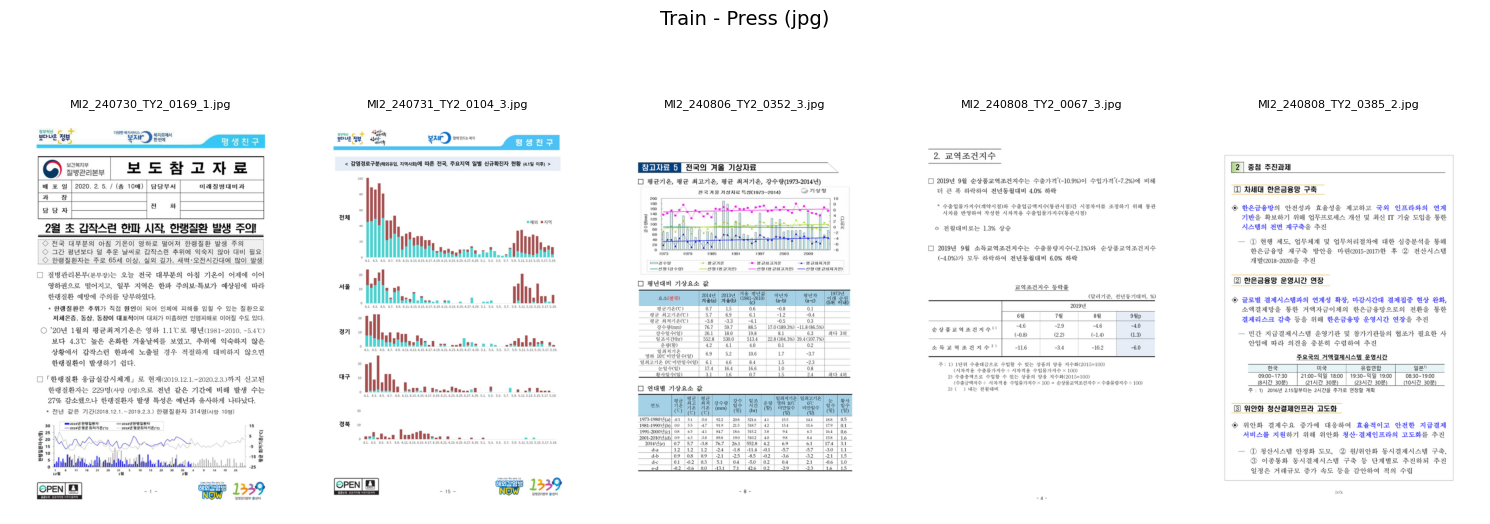

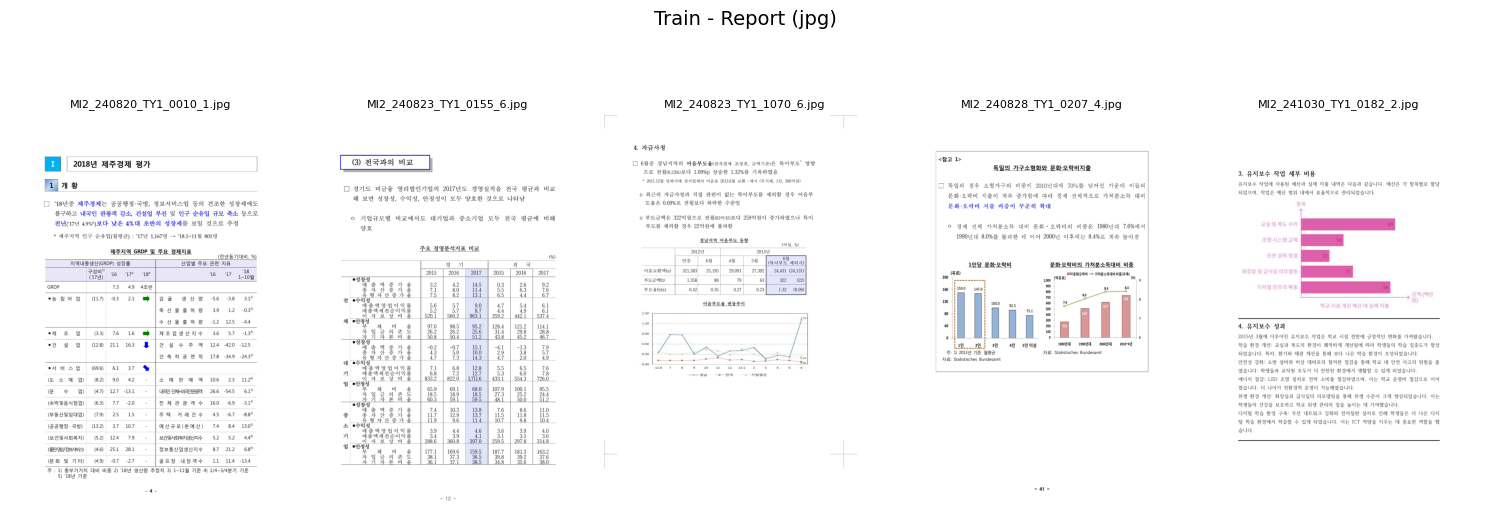

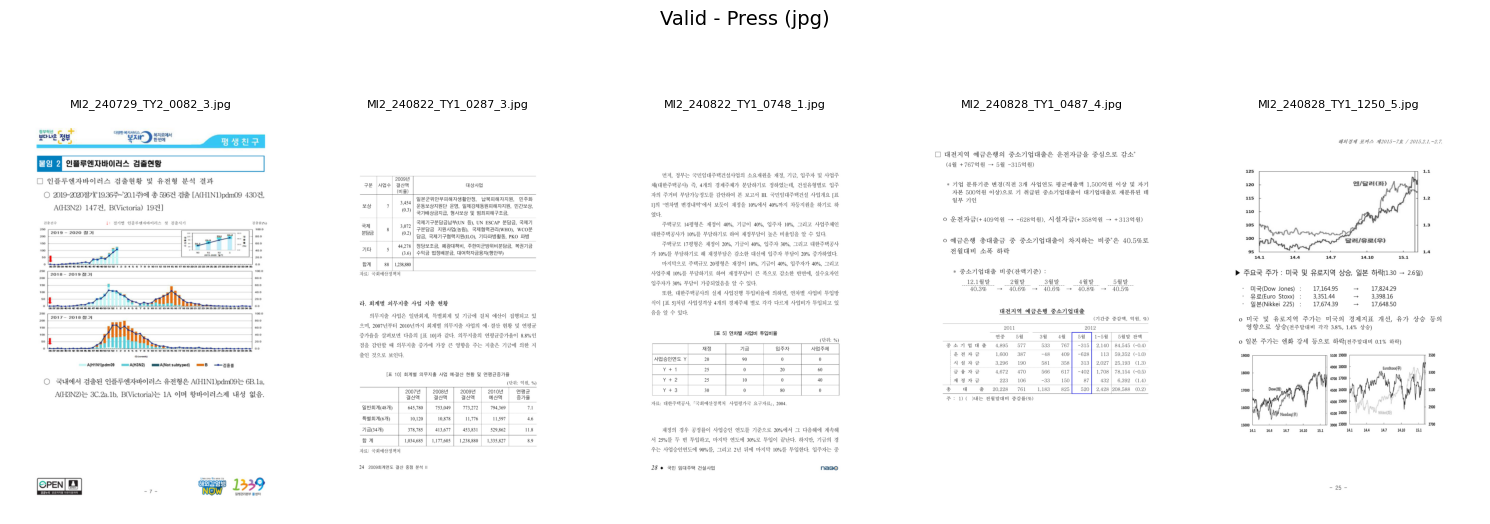

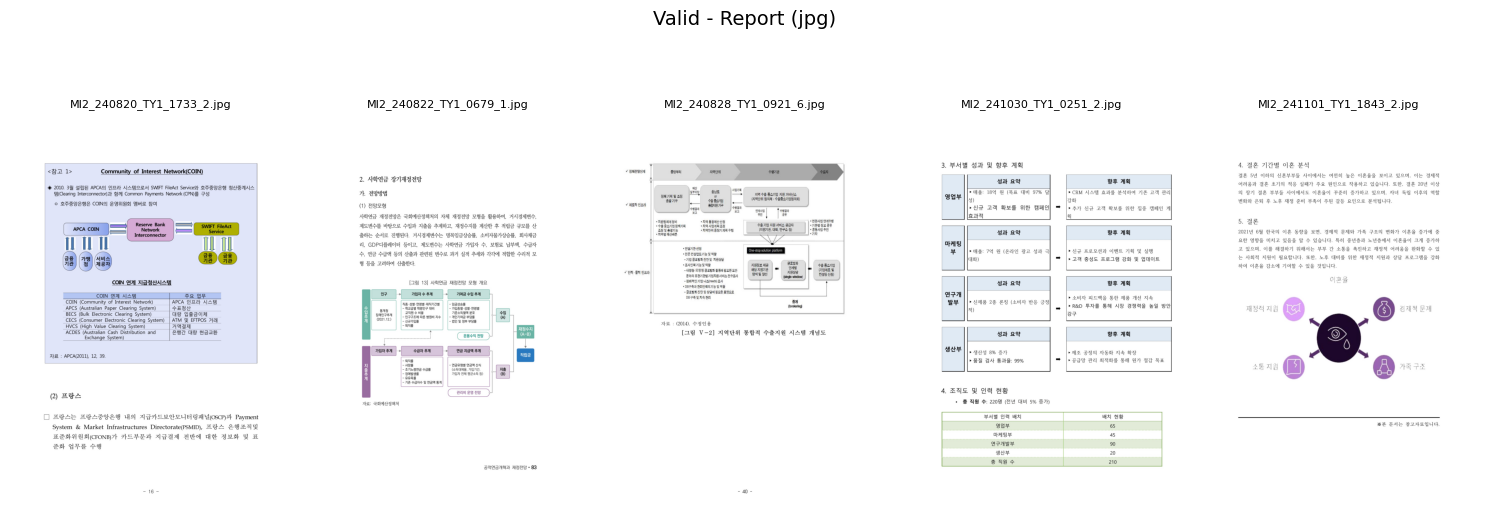

In [7]:
def show_image_row(paths: List[Path], title: str) -> None:
    if not paths:
        display(Markdown(f"*No image samples available for {title}*"))
        return
    cols = len(paths)
    fig, axes = plt.subplots(1, cols, figsize=(3 * cols, 6))
    if cols == 1:
        axes = [axes]
    for ax, path in zip(axes, paths):
        with Image.open(path) as img:
            ax.imshow(img)
        ax.axis("off")
        ax.set_title(path.name, fontsize=8)
    fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

for record in SAMPLED_CATEGORIES:
    if record["modality"].lower() != "jpg":
        continue
    show_image_row(record["samples"], f"{record['collection'].title()} - {record['category'].title()} ({record['modality']})")